# Scrape data from Goodreads.com 📚

---

### **Objective**
I will scrape and analyze data from Goodreads.com. The work is split into two parts, each focusing on different aspects of the data
1. **"Best Books" Analysis**: Explore Goodreads' "Best Books" lists for a specific year.
2. **Author-Level Analysis**: Study the trends and patterns in the works of a specific author.

---

### **Instructions**

#### **Task 1: Best Books**

[Best Books of 2023](https://www.goodreads.com/list/best_of_year/2023) 



**Tasks**:
1. Scrape data from the Goodreads "Best Books of 2023" list:
   - **URL**: https://www.goodreads.com/list/best_of_year/2023 (replace the year with your assigned year). You can also use the table above.
2. Collect the following data for each book:
   - Title
   - Publication date (first published)
   - Author
   - Genre (if available, and feel free to pick the first genre listed)
   - Average rating
   - Number of ratings
   - Number of pages
   - Rank
   - Language (if available)
   - Number of people who are crrently reading (if available)
   - Number of people who want to read (if available)
3. Perform the following analyses:
   - **Genre ratings**:
       - Compare average ratings across genres. Which 2-3 genres tends to have the highest ratings? Create a table showing average rating score, and average rank by genre.
   - **Popularity and ratings**:
       - Examine whether books with more ratings tend to have higher or lower average scores. Create a scatterplot showing the relationship between the number of ratings and average rating. On the x-axis, you should have **number of ratings**; on the y-axis, you should have **average rating**.

---

#### **Task 2: Author-Level Analysis**

| Author              | Author Goodreads link                               | Birthday       |
|---------------------|--------------------------------------------------------------------|----------------|
| Stephen King        | [Stephen King](https://www.goodreads.com/author/list/3389)         | Sep 21, 1947   |



**Tasks**:
1. Scrape all books by your assigned author:
   - Use the link provided for your author.
2. Collect the following data for each book:
   - Title
   - Publication date (first published)
   - Author
   - Genre (if available, and feel free to pick the first genre listed)
   - Average rating
   - Number of ratings
   - Number of pages
   - Rank (from the books written by the author)
   - Language (if available)
   - Number of people who are currently reading (if available)
   - Number of people who want to read (if available)
3. Perform the following analyses:
   - **Language Distribution**:
     - How many books has the author published in English? In other languages? Create a table showing the count of books by language.
   - **Author's Age and Page Count**:
     - Do authors tend to write longer books as they age? Use the author's birthday to calculate their age at the time of each book's publication. Create a line plot with **author's age** on the x-axis and **page count** on the y-axis.
   - **Author's Age and Rating**:
     - For English-only books, create a line plot with **author's age** on the x-axis and **average rating** on the y-axis.
     - Repeat the analysis including books in languages other than English. Does your interpretation change?
   - **Pages vs. Ratings**:
     - Is there a relationship between the number of pages and a book's average rating? Create a scatterplot with **page count** on the x-axis and **average rating** on the y-axis.
   - **Interest on a book**:
     - Is there a relationship between the number of people who are currently reading the book and the number of people who left a rating? Create a scatterplot with **number of people who are currently reading** on the x-axis and **number of ratings** on the y-axis. Create a second scatterplot with **average rating** on the y-axis. Do books with more interest tend to receive higher ratings?

---


# **Data Scraping Overview**

Below is a concise report focusing **exclusively** on the **data scraping** portion of the project, including:
- A single-pass scraping function for a Goodreads list
- A batch-based scraping approach for a larger author-level dataset
- Combining partial outputs into a single CSV

---

## **Table of Contents**
1. [Helper Function and Scraping Function](#1-scraping-function)  
2. [Scraping in Batches](#2-scraping-in-batches)  
3. [Data Merging & Saving](#3-data-merging--saving)  

---

<a id="imports--setup1"></a>
## 2. Imports & Setup

In [74]:
# For Selenium WebDriver
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# For HTML parsing
from bs4 import BeautifulSoup
import json

# Set default plot style
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")


---

<a id="1-scraping-function"></a>
## 1. Helper function and scraping Function

**Note on Collecting the "Language" Field**  
One of the biggest challenges I encountered was extracting the `Language` data. Initially, I attempted to locate and parse it directly via ChromeDriver and XPath, but this was problematic because the `Language` information is buried within many nested tags. Relying on Selenium to directly access such deeply embedded JSON often threw exceptions or returned incomplete data, jeopardizing the integrity of the entire scraping process.

To mitigate this risk, I introduced two **helper functions**:

1. **`html_save(url)`**:  
   - This function navigates to a webpage using a headless browser (Chrome or Firefox).  
   - It then **retrieves the entire HTML** and saves it to a local file (`temp_language_content.html`).  

2. **`getLanguage(file_path)`**:  
   - This function opens the locally saved HTML file and uses **BeautifulSoup** to search for the `<script type='application/ld+json'>` block.  
   - It extracts the JSON content, parses it (with `json.loads`), and returns the value for the `"inLanguage"` key.  
   - Finally, it **deletes** the temporary HTML file to keep the workspace clean.

By adopting this **two-step approach**—saving the HTML, then parsing out the language data—the scraping process became significantly more **robust**. Even if the DOM structure varies or the JavaScript content loads asynchronously, we still have a complete snapshot of the final HTML. This method minimizes the possibility of partial or corrupted data that can occur when using a direct XPath to parse deeply nested script tags. As a result, collecting the `Language` field is now more reliable and


As for the scraping function **compact function** (e.g., `data_scraping`) handles the following steps:

1. Visits each page of the “Best Books of [Year]” list.  
2. Collects rank and book links from each row in the table.  
3. Visits each book link to gather details (title, author, average rating, etc.).  
4. Logs progress to a text file (`scraping_log.txt`) using standard output redirection.

Within the function, we incorporate:
- **Error handling** via `try-except` blocks to guard against unexpected page structures.
- **Sleep intervals** to allow time for pages to load.
- **Language extraction** by **saving the HTML** and parsing `application/ld+json` with BeautifulSoup.

---

In [ ]:
from pathlib import Path

def html_save(url):
    """
    Saves the HTML content of the given URL using Firefox or Chrome, 
    returns the file path.
    """
    # Initialize a separate WebDriver (could be Firefox if installed)
    browser = webdriver.Chrome()  # or webdriver.Firefox()
    browser.get(url)
    html_content = browser.page_source
    browser.close()
    
    soup = BeautifulSoup(html_content, 'html.parser')
    html_save_path = Path(os.getcwd()) / "temp_language_content.html"
    
    with open(html_save_path, 'wt', encoding='utf-8') as f:
        f.write(soup.prettify())
    return html_save_path

def getLanguage(file_path):
    """
    Extracts 'inLanguage' from the JSON data in <script type='application/ld+json'>.
    Then deletes the file to keep workspace clean.
    """
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            html_content = file.read()
        
        start = html_content.find('<script type="application/ld+json">') + len('<script type="application/ld+json">')
        end = html_content.find('</script>', start)
        json_data = html_content[start:end].strip()
        
        parsed_data = json.loads(json_data)
        language = parsed_data.get("inLanguage", "N/A")
    except Exception:
        language = "N/A"
    
    # remove the temp file
    os.remove(file_path)
    return language


In [ ]:
import pandas as pd
import os

def save_to_csv(data, output_dir, file_name):
    """
    Saves a DataFrame to a CSV file in the specified directory.
    
    Parameters:
        data (pd.DataFrame or dict): The data to be saved. If it's a dictionary, it will be converted to a DataFrame.
        output_dir (str): The directory where the CSV file should be saved.
        file_name (str): The name of the CSV file (without extension).
    
    Returns:
        str: The full path to the saved CSV file.
    """
    # Ensure the data is a DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Create the full file path
    file_path = os.path.join(output_dir, f"{file_name}.csv")
    
    # Save the DataFrame to CSV
    data.to_csv(file_path, index=False, encoding='utf-8')
    
    print(f"Data saved to {file_path}")
    return file_path


In [ ]:
import sys
import time
def data_scraping(baseURL, log_name, num_web_page):
    """
    Scrapes Goodreads "Best Books of [Year]" pages to collect:
      - Rank, Book Link, Title, Author, Genre, Language, etc.
    
    Parameters:
        baseURL (str): The base URL for the 'Best Books of [Year]' list.
        log_name (str): The name of the log file to record the process.
        num_web_page (int): Number of pages to scrape.
    
    Returns:
        pd.DataFrame: Contains the collected fields for each book.
    """
    
    # Prepare log file
    log_file = open(log_name, "a", encoding="utf-8")
    sys.stdout = log_file
    sys.stderr = log_file
    
    # Initialize WebDriver (ChromeDriver)
    driver = webdriver.Chrome()
    
    # Lists to store final results
    titles, authors, genres = [], [], []
    languages, average_ratings, num_ratings = [], [], []
    publication_dates, pages, currently_reading, want_to_read = [], [], [], []
    all_ranks, book_links = [], []
    
    # 1. Loop through pages to capture rank & link
    for i in range(1, num_web_page + 1):
        print(f'Processing page {i}')
        sys.stdout.flush()
        
        targetURL = f"{baseURL}&page={i}"
        driver.get(targetURL)
        time.sleep(5)  # Wait for page to load
        
        # Collect ranks
        ranks = []
        rows = driver.find_elements(By.XPATH, '//*[@id="all_votes"]/table/tbody/tr')
        for row in rows:
            try:
                rank = row.find_element(By.XPATH, './td[@class="number"]').text.strip()
                ranks.append(rank)
                # Book link
                href = row.find_element(By.XPATH, './td[3]/a').get_attribute('href')
                book_links.append(href)
            except Exception as e:
                ranks.append("N/A")
                book_links.append("N/A")
        
        print(f"Collected {len(ranks)} ranks on page {i}")
        all_ranks.extend(ranks)
    
    # 2. Visit each book link to gather details
    for rank, link in zip(all_ranks, book_links):
        try:
            driver.get(link)
            time.sleep(2)
            
            # Basic fields
            title = driver.find_element(By.XPATH, '//h1[@class="Text Text__title1"]').text
            author = driver.find_element(By.XPATH, '//span[@class="ContributorLink__name"]').text
            genre = driver.find_element(By.XPATH, '(//div[@class="BookPageMetadataSection__genres"]'
                                                  '//span[@class="Button__labelItem"])[1]').text
            avg_rating = driver.find_element(By.XPATH, '//div[@class="RatingStatistics__rating"]').text
            num_rating = driver.find_element(By.XPATH, '//div[@class="RatingStatistics__meta"]').text.split(" ratings")[0].strip()
            page = driver.find_element(By.XPATH, '//p[@data-testid="pagesFormat"]').text.split(" pages")[0]
            pub_date = driver.find_element(By.XPATH, '//p[@data-testid="publicationInfo"]').text.replace("First published", "").strip()
            reading_now = driver.find_element(By.XPATH, '//div[@data-testid="currentlyReadingSignal"]').text.split(" people")[0]
            want_read = driver.find_element(By.XPATH, '//div[@data-testid="toReadSignal"]').text.split(" people")[0]
            
            # Language extracted by saving HTML locally, then parsing
            lang_html_path = html_save(link)  # We'll define html_save later
            language = getLanguage(lang_html_path)  # We'll define getLanguage later
            
            # Append results
            titles.append(title)
            authors.append(author)
            genres.append(genre)
            languages.append(language)
            average_ratings.append(avg_rating)
            num_ratings.append(num_rating)
            publication_dates.append(pub_date)
            pages.append(page)
            currently_reading.append(reading_now)
            want_to_read.append(want_read)
            
            print(f"Rank: {rank} | Title: {title} | Language: {language}")
            sys.stdout.flush()
        except Exception as e:
            # Fallback
            titles.append("N/A")
            authors.append("N/A")
            genres.append("N/A")
            languages.append("N/A")
            average_ratings.append("N/A")
            num_ratings.append("N/A")
            publication_dates.append("N/A")
            pages.append("N/A")
            currently_reading.append("N/A")
            want_to_read.append("N/A")
    
    # Cleanup
    driver.quit()
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    log_file.close()
    
    # Create final DataFrame
    df = pd.DataFrame({
        "Rank": all_ranks,
        "Book Link": book_links,
        "Title": titles,
        "Author": authors,
        "Genre": genres,
        "Language": languages,
        "Average Rating": average_ratings,
        "Number of Ratings": num_ratings,
        "Publication Date": publication_dates,
        "Number of Pages": pages,
        "Currently Reading": currently_reading,
        "Want to Read": want_to_read
    })
    return df


In [ ]:
# Example usage for Task 1
baseURL_task1 = "https://www.goodreads.com/list/best_of_year/2023?id=183940.Best_Books_of_2023"
log_file_task1 = "scraping_log.txt"
num_pages_task1 = 12 

books_df_1 = data_scraping(baseURL_task1, log_file_task1, num_pages_task1)
books_df_1.to_csv("data/books_data_1.csv", index=False, encoding='utf-8')




<a id="2-scraping-in-batches"></a>
## 2. Scraping in Batches

I used this approach to collect data for Task 2

When tackling a **larger dataset**—for instance, all works by a prolific author—scraping everything in one pass can be risky. If an error occurs midway, you lose all progress. Therefore, we:

1. **First gather** the full list of book links with a lighter function (e.g., `get_book_links`).  
2. **Divide** those links into smaller slices (e.g., `[0, 100]`, `[100, 200]`, etc.).  
3. **Scrape each slice** using a function like `data_scraping_2`, which retries each book up to three times before skipping it.  
4. **Optionally run** multiple slices in parallel (multi-threading or multiple notebooks) if system resources allow.

This approach ensures we don’t have to re-scrape the entire dataset from scratch if a single link causes trouble.

---

In [ ]:
def get_book_links(baseURL, num_web_page, log_name):
    """
    Function to extract book links from the given pages and log the process.
    """
    # Open the log file for appending
    log_file = open(log_name, "a", encoding="utf-8")

    # Redirect print and errors to the log file
    sys.stdout = log_file
    sys.stderr = log_file

    driver = webdriver.Chrome()
    wait = WebDriverWait(driver, 10)
    book_links = []

    # Loop through pages to get all book links
    # Loop through pages
    for i in range(1, num_web_page + 1):  
        print(f'Processing page {i}')
        sys.stdout.flush()
        targetURL = f"{baseURL}?page={i}"
        driver.get(targetURL)
        time.sleep(5)  # Allow the page to load
        rows = driver.find_elements(By.XPATH, '//table[@class="tableList"]/tbody/tr')
        print(f'Number of rows found: {len(rows)}')

        # Extract book links from each row
        for row in rows:
            try:
                href = row.find_element(By.XPATH, './td[2]/a').get_attribute('href')
                book_links.append(href)
                print(f'Current href: {href}')
            except Exception as e:
                print(f"Error extracting rank or book link: {e}")
                sys.stdout.flush()
                book_links.append("N/A")

    driver.quit()

    # Restore stdout and stderr
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    log_file.close()

    return book_links

In [ ]:
def data_scraping_2(book_links, log_name, start, end):
    """
    Function to scrape book details from each book link, including language using html_save and getLanguage.
    Retries up to three times with a wait time before retrying if data collection fails before moving to the next book.
    Sets 'N/A' for fields that cannot be found.
    """
    # Create and open the log file for appending
    log_file = open(log_name, "a", encoding="utf-8")

    # Redirect print and errors to the log file
    sys.stdout = log_file
    sys.stderr = log_file

    # Initialize WebDriver
    driver = webdriver.Chrome()
    wait = WebDriverWait(driver, 10)

    # Initialize lists for storing data
    titles, authors, genres = [], [], []
    languages, average_ratings, num_ratings = [], [], []
    publication_dates, pages, currently_reading, want_to_read = [], [], [], []

    # Start indexing from the start index
    i = start  
    for href in book_links[start:end]:
        retries = 0
        success = False
        while retries < 3 and not success:
            try:
                driver.get(href)
                time.sleep(2)  # Allow initial page load

                # Extract book details
                try:
                    title = wait.until(EC.presence_of_element_located((By.XPATH, '//h1[@class="Text Text__title1"]'))).text
                except Exception:
                    title = "N/A"

                try:
                    author = wait.until(EC.presence_of_element_located((By.XPATH, '//span[@class="ContributorLink__name"]'))).text
                except Exception:
                    author = "N/A"

                try:
                    genre = wait.until(EC.presence_of_element_located((By.XPATH, '(//div[@class="BookPageMetadataSection__genres"]//span[@class="Button__labelItem"])[1]'))).text
                except Exception:
                    genre = "N/A"

                try:
                    avg_rating = wait.until(EC.presence_of_element_located((By.XPATH, '//div[@class="RatingStatistics__rating"]'))).text
                except Exception:
                    avg_rating = "N/A"

                try:
                    num_rating = wait.until(EC.presence_of_element_located((By.XPATH, '//div[@class="RatingStatistics__meta"]'))).text.split(" ratings")[0].strip()
                except Exception:
                    num_rating = "N/A"

                try:
                    page = wait.until(EC.presence_of_element_located((By.XPATH, '//p[@data-testid="pagesFormat"]'))).text.split(" pages")[0]
                except Exception:
                    page = "N/A"

                try:
                    pub_date = wait.until(EC.presence_of_element_located((By.XPATH, '//p[@data-testid="publicationInfo"]'))).text.replace("First published", "").strip()
                except Exception:
                    pub_date = "N/A"

                try:
                    reading_now = wait.until(EC.presence_of_element_located((By.XPATH, '//div[@data-testid="currentlyReadingSignal"]'))).text.split(" people")[0]
                except Exception:
                    reading_now = "N/A"

                try:
                    want_read = wait.until(EC.presence_of_element_located((By.XPATH, '//div[@data-testid="toReadSignal"]'))).text.split(" people")[0]
                except Exception:
                    want_read = "N/A"

                try:
                    # Use html_save and getLanguage to extract language
                    file_path = html_save(href)
                    language = getLanguage(file_path)
                except Exception:
                    language = "N/A"

                # Append details to lists
                titles.append(title)
                authors.append(author)
                genres.append(genre)
                average_ratings.append(avg_rating)
                num_ratings.append(num_rating)
                pages.append(page)
                publication_dates.append(pub_date)
                currently_reading.append(reading_now)
                want_to_read.append(want_read)
                languages.append(language)

                # Log book details immediately
                print(f"Processed Book {i + 1}:")
                print(f"  Book Link: {href}")
                print(f"  Title: {title}")
                print(f"  Author: {author}")
                print(f"  Genre: {genre}")
                print(f"  Average Rating: {avg_rating}")
                print(f"  Number of Ratings: {num_rating}")
                print(f"  Number of Pages: {page}")
                print(f"  Publication Date: {pub_date}")
                print(f"  Currently Reading: {reading_now}")
                print(f"  Want to Read: {want_read}")
                print(f"  Language: {language}")
                print("-" * 40)
                sys.stdout.flush()
                success = True  # Mark success if no exception occurred
            except Exception as e:
                retries += 1
                print(f"Error processing book at {href}, attempt {retries}: {e}")
                sys.stdout.flush()
                if retries < 3:
                    wait_time = retries * 5  # Increasing wait time with each retry (e.g., 5s, 10s, 15s)
                    print(f"Waiting for {wait_time} seconds before retrying...")
                    time.sleep(wait_time)
                if retries == 3:
                    # If all retries fail, append "N/A" values for all fields
                    print(f"Failed to process book at {href} after 3 attempts. Moving on.")
                    titles.append("N/A")
                    authors.append("N/A")
                    genres.append("N/A")
                    average_ratings.append("N/A")
                    num_ratings.append("N/A")
                    pages.append("N/A")
                    publication_dates.append("N/A")
                    currently_reading.append("N/A")
                    want_to_read.append("N/A")
                    languages.append("N/A")

        # Increment counter after all retries, regardless of success
        i += 1

    driver.quit()

    # Restore stdout and stderr
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    log_file.close()

    # Create the DataFrame
    return pd.DataFrame({
        "Book Link": book_links[start:end],
        "Title": titles,
        "Author": authors,
        "Genre": genres,
        "Language": languages,
        "Average Rating": average_ratings,
        "Number of Ratings": num_ratings,
        "Publication Date": publication_dates,
        "Number of Pages": pages,
        "Currently Reading": currently_reading,
        "Want to Read": want_to_read,
    })


In [ ]:
baseURL_author = "https://www.goodreads.com/author/list/3389.Stephen_King"
log_file_task2 = "scraping_log_2.txt"
num_web_page_author = 88  # e.g. 88 pages
book_links = get_book_links(baseURL_author, num_web_page_author, log_file_task2)

print("Total book links found:", len(book_links))

# Example: Scrape 0-100
books_df_2_p1 = data_scraping_2(book_links, log_file_task2, 0, 100)
# Repeat for 100-200, 200-300, etc.


In [ ]:
baseURL = "https://www.goodreads.com/author/list/3389.Stephen_King"
log_name = "scraping_log_2.txt"
num_web_page = 88

# Step 1: Get all book links
book_links = get_book_links(baseURL, num_web_page, log_name)

In [ ]:
# Step 2: Collecting data
# Below is a code snippet that scrapes Stephen King's books in batches,
# using exactly 26 lines. Each line handles a specific range of book indices,
# and the final line captures the remaining books from 2500 to 2617. (There are 2616 books)

books_df_2_p1  = data_scraping_2(book_links, log_name, 0,    100)
books_df_2_p2  = data_scraping_2(book_links, log_name, 100,  200)
books_df_2_p3  = data_scraping_2(book_links, log_name, 200,  300)
books_df_2_p4  = data_scraping_2(book_links, log_name, 300,  400)
books_df_2_p5  = data_scraping_2(book_links, log_name, 400,  500)
books_df_2_p6  = data_scraping_2(book_links, log_name, 500,  600)
books_df_2_p7  = data_scraping_2(book_links, log_name, 600,  700)
books_df_2_p8  = data_scraping_2(book_links, log_name, 700,  800)
books_df_2_p9  = data_scraping_2(book_links, log_name, 800,  900)
books_df_2_p10 = data_scraping_2(book_links, log_name, 900,  1000)
books_df_2_p11 = data_scraping_2(book_links, log_name, 1000, 1100)
books_df_2_p12 = data_scraping_2(book_links, log_name, 1100, 1200)
books_df_2_p13 = data_scraping_2(book_links, log_name, 1200, 1300)
books_df_2_p14 = data_scraping_2(book_links, log_name, 1300, 1400)
books_df_2_p15 = data_scraping_2(book_links, log_name, 1400, 1500)
books_df_2_p16 = data_scraping_2(book_links, log_name, 1500, 1600)
books_df_2_p17 = data_scraping_2(book_links, log_name, 1600, 1700)
books_df_2_p18 = data_scraping_2(book_links, log_name, 1700, 1800)
books_df_2_p19 = data_scraping_2(book_links, log_name, 1800, 1900)
books_df_2_p20 = data_scraping_2(book_links, log_name, 1900, 2000)
books_df_2_p21 = data_scraping_2(book_links, log_name, 2000, 2100)
books_df_2_p22 = data_scraping_2(book_links, log_name, 2100, 2200)
books_df_2_p23 = data_scraping_2(book_links, log_name, 2200, 2300)
books_df_2_p24 = data_scraping_2(book_links, log_name, 2300, 2400)
books_df_2_p25 = data_scraping_2(book_links, log_name, 2400, 2500)
books_df_2_p26 = data_scraping_2(book_links, log_name, 2500, 2627)
books_df_2_p27 = data_scraping_2(book_links, log_name, 2600, 2617)

In [ ]:
save_to_csv(books_df_2_p1, './data/book_scrape_2', 'books_df2_p1')
save_to_csv(books_df_2_p2, './data/book_scrape_2', 'books_df2_p2')
save_to_csv(books_df_2_p3, './data/book_scrape_2', 'books_df2_p3')
save_to_csv(books_df_2_p5, './data/book_scrape_2', 'books_df2_p5')
save_to_csv(books_df_2_p6, '../data/book_scrape_2', 'books_df2_p6')
save_to_csv(books_df_2_p7, '../data/book_scrape_2', 'books_df2_p7')
save_to_csv(books_df_2_p8, '../data/book_scrape_2', 'books_df2_p8')
save_to_csv(books_df_2_p9, '../data/book_scrape_2', 'books_df2_p9')
save_to_csv(books_df_2_p10, '../data/book_scrape_2', 'books_df2_p10')
save_to_csv(books_df_2_p11, '../data/book_scrape_2', 'books_df2_p11')
save_to_csv(books_df_2_p12, '../data/book_scrape_2', 'books_df2_p12')
save_to_csv(books_df_2_p13, '../data/book_scrape_2', 'books_df2_p13')
save_to_csv(books_df_2_p14, '../data/book_scrape_2', 'books_df2_p14')
save_to_csv(books_df_2_p15, '../data/book_scrape_2', 'books_df2_p15')
save_to_csv(books_df_2_p16, '../data/book_scrape_2', 'books_df2_p16')
save_to_csv(books_df_2_p17, '../data/book_scrape_2', 'books_df2_p17')
save_to_csv(books_df_2_p18, '../data/book_scrape_2', 'books_df2_p18')
save_to_csv(books_df_2_p19, '../data/book_scrape_2', 'books_df2_p19')
save_to_csv(books_df_2_p20, '../data/book_scrape_2', 'books_df2_p20')
save_to_csv(books_df_2_p21, '../data/book_scrape_2', 'books_df2_p21')
save_to_csv(books_df_2_p22, '../data/book_scrape_2', 'books_df2_p22')
save_to_csv(books_df_2_p23, '../data/book_scrape_2', 'books_df2_p23')
save_to_csv(books_df_2_p24, '../data/book_scrape_2', 'books_df2_p24')
save_to_csv(books_df_2_p25, '../data/book_scrape_2', 'books_df2_p25')
save_to_csv(books_df_2_p26, '../data/book_scrape_2', 'books_df2_p26')
save_to_csv(books_df_2_p27, '../data/book_scrape_2', 'books_df2_p27')

<a id="3-data-merging--saving"></a>
## 3. Data Merging & Saving

After generating partial CSVs (one for each slice), we **combine** them into a single final CSV. A helper function (e.g., `combine_csv_files`) can:

1. Read each partial CSV in numerical order.  
2. **Concatenate** them into a single DataFrame.  
3. Export that DataFrame to a **final** CSV (e.g., `books_data_2.csv`).  

This modular workflow ensures robust error handling, efficient retries, and a convenient final dataset for downstream analysis. 


In [ ]:
import os
import pandas as pd

def combine_csv_files(input_folder, output_file, prefix, num_files):
    """
    Reads multiple CSV files matching a given prefix and numerical sequence,
    then combines them into a single DataFrame, which is finally saved as a
    single CSV file.

    This approach is particularly helpful when large datasets have been scraped
    or processed in smaller chunks (e.g., partial batches). By systematically
    iterating over each expected file, you can ensure no subset is missed, and
    easily catch if a particular chunk is missing or incorrectly named.

    Parameters:
        input_folder (str): The directory containing the partial CSV files.
        output_file (str): The full path (including filename) for the final combined CSV.
        prefix (str): The prefix used for naming the partial CSV files (e.g., "books_df2_p").
        num_files (int): The total number of expected files to combine in sequential order
                         from 1 up to num_files.

    Returns:
        None. A combined CSV file is written to `output_file`.
    """
    combined_df = pd.DataFrame()

    for i in range(1, num_files + 1):
        file_path = os.path.join(input_folder, f"{prefix}{i}.csv")
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path)
            combined_df = pd.concat([combined_df, temp_df], ignore_index=True)
        else:
            print(f"File not found: {file_path}")

    combined_df.to_csv(output_file, index=False)
    print(f"Combined CSV file saved to: {output_file}")


In [ ]:
# Define the input folder and output file paths
input_folder = "/Users/quynhanh2004/Documents/GitHub/take-home-final-annepham1512/exams/final/data/book_scrape_2" 
output_file = "/Users/quynhanh2004/Documents/GitHub/take-home-final-annepham1512/exams/final/data/books_data_2.csv"  # Save the combined file outside the folder

# Combine the CSV files
combine_csv_files(input_folder, output_file, prefix="books_df2_p", num_files=27)


In [ ]:
# Removing folder after done using
import shutil

shutil.rmtree("./data/book_scrape_2", ignore_errors=True)


In [ ]:
# Moving log files to log folder
os.makedirs("log", exist_ok=True)
for lf in ["scraping_log.txt", "scraping_log_2.txt"]:
    if os.path.exists(lf):
        shutil.move(lf, f"log/{lf}")

# **Task 1: Detailed Analysis of Goodreads Data for "Best Books" (Year 2023)**

## Table of Contents
1. [Introduction](#introduction)
2. [Environment Setup](#environment-setup)
3. [Loading the Data](#loading-data)
4. [Data Cleaning and Preparation](#data-cleaning)
   - [Converting Columns to Numeric Types](#converting-columns)
   - [Quick Inspection](#quick-inspection)
5. [Visualization and Explanation](#analysis-tasks)
   - [1. Genre Ratings Analysis](#genre-ratings-analysis)
     - [Goal](#goal-genre)
     - [Steps](#steps-genre)
   - [2. Popularity vs. Average Ratings](#popularity-vs-ratings)
     - [Goal](#goal-popularity)
     - [Steps](#steps-popularity)
6. [Reporting Findings](#reporting)


---

<a id="introduction"></a>

## 1. **Introduction**
This document outlines a comprehensive approach to analyze a CSV file containing data about Goodreads' "Best Books of 2023." The **CSV file** is named **`books_data_1.csv`** in our working directory. We aim to complete two primary tasks:

1. **Genre Ratings Analysis**: Determine which genres have the highest average ratings and also examine the average rank by genre.
2. **Popularity vs. Ratings**: Investigate whether books that have more ratings (i.e., more popular) also tend to have higher average ratings, or whether there is no clear relationship.

We will document the reasoning and transformations in *Markdown* format so that each step is clear.

---

<a id="environment-setup"></a>

## 2. **Environment Setup**
Before performing any analysis, we must ensure that we have the necessary Python libraries installed:

- **pandas** for data manipulation
- **numpy** for numerical computing
- **matplotlib** and/or **seaborn** for data visualization



In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting a style for plots (optional)
sns.set_style("whitegrid")


## 3. **Loading the Data** <a id="loading-data"></a>

In [65]:
df = pd.read_csv("./data/books_data_1.csv")
df.head()


,Unnamed: 0,Rank,Book Link,Title,Author,Genre,Language,Average Rating,Number of Ratings,Publication Date,Number of Pages,Currently Reading,Want to Read
0,0,1,https://www.goodreads.com/book/show/61431922-f...,Fourth Wing,Rebecca Yarros,Dragons,English,4.57,"2,257,987","May 2, 2023",517,143k,1m
1,1,2,https://www.goodreads.com/book/show/61718053-h...,Happy Place,Emily Henry,Romance,English,3.97,"1,120,516","April 25, 2023",400,51.9k,940k
2,2,3,https://www.goodreads.com/book/show/62047984-y...,Yellowface,R.F. Kuang,Fiction,English,3.75,"696,677","May 16, 2023",336,32k,839k
3,3,4,https://www.goodreads.com/book/show/60784546-d...,Divine Rivals,Rebecca Ross,Romance,English,4.18,"559,773","April 4, 2023",357,37.9k,799k
4,4,5,https://www.goodreads.com/book/show/61326735-l...,"Love, Theoretically",Ali Hazelwood,Romance,English,4.10,"496,025","June 13, 2023",389,13.2k,513k


## 4. **Data Cleaning and Preparation** <a id="data-cleaning"></a>

Real-world data often has inconsistent formats—particularly with numeric columns stored as strings (e.g., `"2,257,987"`, `"12.5k"`, or `"Unknown Binding"`). We must convert these to numeric types for meaningful analysis.

### 4.1 **Converting Columns to Numeric Types** <a id="converting-columns"></a>

In [66]:
def convert_string_to_int(x):
    """
    Convert values like:
      - '2,257,987' -> 2257987
      - '143k' -> 143000
      - '12.5k' -> 12500
    Return np.nan if conversion fails.
    """
    if pd.isna(x):
        return np.nan

    x = str(x).lower().replace(',', '').strip()  # remove commas, handle spaces

    # If the value ends with 'k' or includes 'k', multiply by 1000
    if 'k' in x:
        x = x.replace('k', '')
        try:
            return int(float(x) * 1000)
        except:
            return np.nan

    # If there's a decimal, try to parse as float -> int
    if '.' in x:
        try:
            return int(float(x))
        except:
            return np.nan

    # Attempt direct integer conversion
    try:
        return int(x)
    except:
        return np.nan

# Convert relevant columns using our helper function
for col in ["Number of Ratings", "Currently Reading", "Want to Read"]:
    if col in df.columns:
        df[col] = df[col].apply(convert_string_to_int)

# Convert "Average Rating" to float
if "Average Rating" in df.columns:
    df["Average Rating"] = pd.to_numeric(df["Average Rating"], errors='coerce')

# Convert "Rank" to numeric
if "Rank" in df.columns:
    df["Rank"] = pd.to_numeric(df["Rank"], errors='coerce')

# Convert "Number of Pages" to integer, handling cases like "Unknown Binding"
def convert_pages(x):
    """
    Attempt to parse the number of pages. Return NaN if not purely numeric.
    """
    if pd.isna(x):
        return np.nan
    x = str(x).replace(',', '').strip()
    if x.isdigit():
        return int(x)
    else:
        return np.nan

if "Number of Pages" in df.columns:
    df["Number of Pages"] = df["Number of Pages"].apply(convert_pages)


Real-world data often has inconsistent formats—particularly with numeric columns stored as strings (e.g., `"2,257,987"`, `"12.5k"`, or `"Unknown Binding"`). We must convert these to numeric types for meaningful analysis.


### 4.2 **Quick Inspection** <a id="quick-inspection"></a>

In [67]:
# Check the structure and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1149 non-null   int64  
 1   Rank               1149 non-null   int64  
 2   Book Link          1149 non-null   object 
 3   Title              1130 non-null   object 
 4   Author             1130 non-null   object 
 5   Genre              1130 non-null   object 
 6   Language           1119 non-null   object 
 7   Average Rating     1130 non-null   float64
 8   Number of Ratings  1130 non-null   float64
 9   Publication Date   1130 non-null   object 
 10  Number of Pages    1118 non-null   float64
 11  Currently Reading  1123 non-null   float64
 12  Want to Read       1129 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 116.8+ KB


In [68]:
# Check for missing values
df.isnull().sum()


Unnamed: 0            0
Rank                  0
Book Link             0
Title                19
Author               19
Genre                19
Language             30
Average Rating       19
Number of Ratings    19
Publication Date     19
Number of Pages      31
Currently Reading    26
Want to Read         20
dtype: int64

In [69]:
# Descriptive statistics for numerical columns
df.describe()

,Unnamed: 0,Rank,Average Rating,Number of Ratings,Number of Pages,Currently Reading,Want to Read
count,1149.000000,1149.000000,1130.000000,1.130000e+03,1118.000000,1123.000000,1129.000000
mean,574.000000,570.134900,3.974425,3.680740e+04,341.470483,3159.866429,51735.130204
std,331.832036,329.781646,0.310612,1.150592e+05,138.403322,8995.598355,95428.140538
min,0.000000,1.000000,2.930000,1.000000e+01,5.000000,2.000000,6.000000
25%,287.000000,288.000000,3.770000,1.790500e+03,288.000000,167.500000,4495.000000
50%,574.000000,575.000000,4.000000,6.479500e+03,336.000000,595.000000,16100.000000
75%,861.000000,858.000000,4.197500,2.802150e+04,399.750000,2837.000000,53700.000000
max,1148.000000,1149.000000,4.830000,2.257987e+06,1387.000000,158000.000000,940000.000000


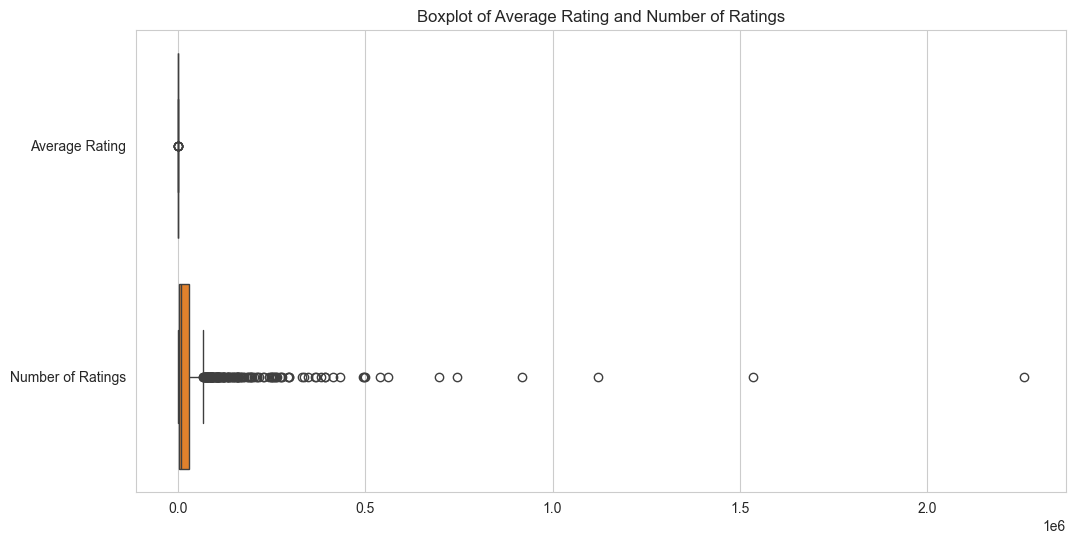

In [70]:
# Boxplot to visualize outliers in 'Average Rating' and 'Number of Ratings'
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Average Rating', 'Number of Ratings']].dropna(), orient='h')
plt.title("Boxplot of Average Rating and Number of Ratings")
plt.show()


In [71]:
# Handling missing values

# Fill numeric columns with median
numeric_columns = ['Number of Ratings', 'Currently Reading', 'Want to Read', 'Average Rating', 'Rank', 'Number of Pages']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Ensure numeric type
        df[col] = df[col].fillna(df[col].median())  # Fill missing values with median

# Fill categorical columns with "Unknown"
categorical_columns = ['Title', 'Author', 'Genres', 'Language', 'Publication Date']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

df.to_csv('./data/cleaned_data/books_data_1_cleaned.csv', index=False)


## 5. **Visualization and Explanation** <a id="analysis-tasks"></a>

For **Task 1: Best Books**, the assignment specifies two main analysis components:

1. **Genre Ratings Analysis**: Compare average ratings across genres and look at their average rank.
2. **Popularity vs. Ratings**: Examine the relationship between the number of ratings (popularity) and average rating.

### 5.1 **Genre Ratings Analysis** <a id="genre-ratings-analysis"></a>

#### **Goal** <a id="goal-genre"></a>

- **Determine which 2–3 genres have the highest average rating.**
- **Examine the average rank within each genre to see if a high rating aligns with a top position in the "best of the year" list.**


#### **Steps** <a id="steps-genre"></a>

1. **Group the DataFrame by Genre.**
2. **Aggregate** to find:
   - **Mean of Average Rating**
   - **Mean of Rank**
3. **Sort** by average rating descending to identify the top genres.



In [4]:
genre_stats = (
    df.groupby('Genre')
      .agg({
          'Average Rating': 'mean',
          'Rank': 'mean'
      })
      .rename(columns={
          'Average Rating': 'Avg_Rating',
          'Rank': 'Avg_Rank'
      })
      .reset_index()
)

# Sort by highest average rating
genre_stats.sort_values(by='Avg_Rating', ascending=False, inplace=True)
genre_stats.head(10)


,Genre,Avg_Rating,Avg_Rank
15,Dragons,4.570,1.0
59,Time Travel,4.555,789.5
27,Lesbian,4.500,702.0
31,Manga,4.495,399.0
12,Cozy Mystery,4.490,410.0
5,Childrens,4.460,838.0
47,Regency,4.440,743.0
11,Cookbooks,4.425,464.0
35,Music,4.410,1063.0
44,Picture Books,4.410,903.0


- **Grouping:** We use `groupby('Genre')` to aggregate data based on each genre.

- **Aggregation:**
  - **Average Rating:** Calculated as the mean rating for each genre.
  - **Rank:** Calculated as the mean rank position for each genre.

- **Renaming Columns:** For clarity, we rename the aggregated columns to `Avg_Rating` and `Avg_Rank`.

- **Sorting:** The genres are sorted in descending order based on `Avg_Rating` to highlight the top-performing genres.

- **Displaying Results:** Using `head(10)` helps us focus on the top 10 genres with the highest average ratings.

### 5.2 **Popularity vs. Average Ratings** <a id="popularity-vs-ratings"></a>


#### **Goal** <a id="goal-popularity"></a>

- **Investigate whether books that have more ratings (i.e., are more popular) also tend to have higher average ratings.**


#### **Steps** <a id="steps-popularity"></a>

1. **Create a Scatter Plot:**
   - **x-axis:** Number of Ratings (popularity)
   - **y-axis:** Average Rating
   - **Optional:** Use a logarithmic scale for the x-axis if the range of Number of Ratings spans from hundreds to millions.

2. **Compute the Correlation Coefficient** to quantify the relationship between the two variables.

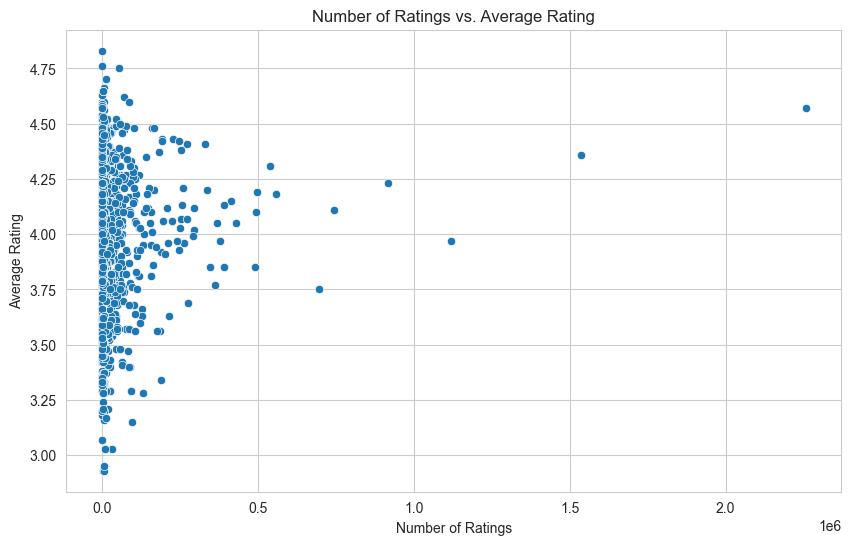

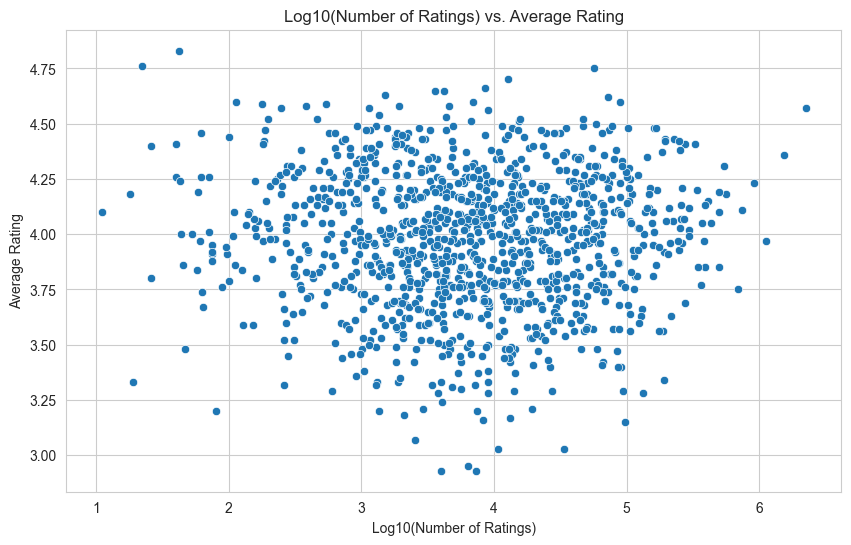

In [5]:
# Basic scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Number of Ratings", y="Average Rating")
plt.title("Number of Ratings vs. Average Rating")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.show()

# Scatter plot with logarithmic scale for x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x=np.log10(df["Number of Ratings"] + 1),  # +1 to avoid log(0)
    y="Average Rating"
)
plt.title("Log10(Number of Ratings) vs. Average Rating")
plt.xlabel("Log10(Number of Ratings)")
plt.ylabel("Average Rating")
plt.show()


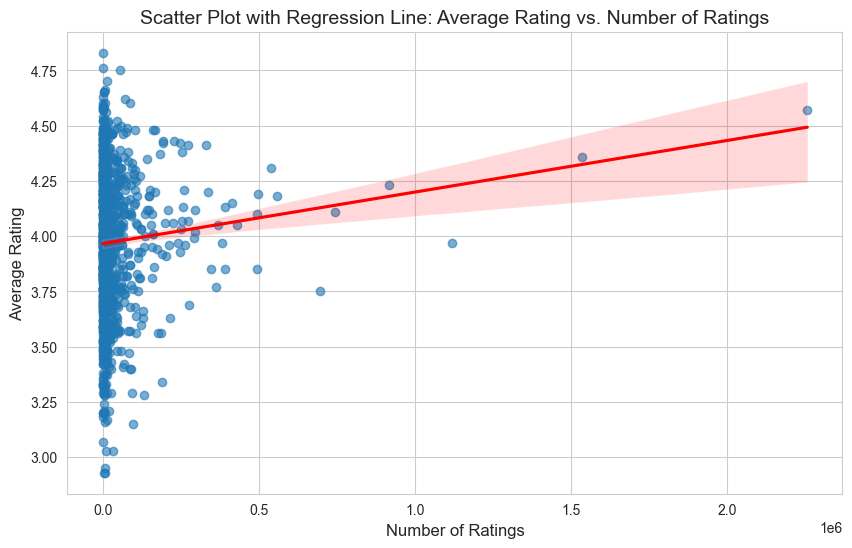

In [ ]:
# Scatter plot with regression line: Average Rating vs. Number of Ratings
plt.figure(figsize=(10, 6))
sns.regplot(
    x=df['Number of Ratings'],  # Replace with your column name for number of ratings
    y=df['Average Rating'],  # Replace with your column name for average rating
    scatter_kws={'alpha': 0.6},  # Adjust scatter point transparency
    line_kws={'color': 'red'}  # Set regression line color
)
plt.title('Scatter Plot with Regression Line: Average Rating vs. Number of Ratings', fontsize=14)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True)
plt.show()

## 6. **Reporting Findings** <a id="reporting"></a>


### **Data Cleaning Steps**

In this task, the dataset was preprocessed and cleaned as follows:
1. **Missing Value Handling**:
   - Numeric columns such as "Number of Ratings", "Currently Reading", "Want to Read", "Average Rating", "Rank", and "Number of Pages" had missing values filled with the median.
   - Categorical columns like "Title", "Author", "Genres", "Language", and "Publication Date" had missing values filled with "Unknown".
2. **Numeric Column Conversion**:
   - Converted columns to proper numeric types to facilitate analysis.
   - Standardized "Publication Date" to a datetime format.
3. **Ready for Analysis**:
   - The dataset is now free of missing values and inconsistencies, ensuring readiness for further analysis.

### **Genre Ratings Analysis**


- **Genre Ratings**

| Genre           | Average Rating | Average Rank |
|------------------|----------------|--------------|
| Dragons         | 4.57           | 1.0          |
| Time Travel     | 4.555          | 789.5        |
| Lesbian         | 4.5            | 702.0        |
| Manga           | 4.495          | 399.0        |
| Cozy Mystery    | 4.49           | 410.0        |
| Childrens       | 4.46           | 838.0        |
| Regency         | 4.44           | 743.0        |
| Cookbooks       | 4.425          | 464.0        |
| Picture Books   | 4.41           | 903.0        |

The genres with the highest ratings are:
   - **Dragons**: Average rating of **4.57**
   - **Time Travel**: Average rating of **4.555**
   - **Lesbian**: Average rating of **4.5**

However, there is a bias in this ranking. If we inlcude the number of books per genre, none of the top 10 highest-rated genres has more than 4 books per genre. Aside from picture books, each genre is made up of 1-2 books. In fact, it is not until the 28th highest-rated genre that we observe a genre with more than 10 books. This suggests that genres with a larger number of books tend to appear further down the ranking list, potentially because maintaining high average ratings becomes challenging as the number of books increases. The highest-rated genres, therefore often consist of a small, select number of books. 

### **Popularity vs. Ratings**

The scatter plot is already shown in the previous part for visualization.

Looking at the scatter plot, one would conjecture that the more higher-rated a book is, the more readers it would attract, therefore more highly-rated reviews are contributed to a title, assuming that would resolutely be the case. A regression line in the scatter plot supports this trend, **that books with greater popularity tend to have slightly higher ratings, however with a weak overall correlation.** 

There is a slight positive correlation between the popularity of a book (measured by the number of ratings) and its average rating. The correlation coefficient is **0.086**, indicating a **weak positive relationship**. 

That remains true: books with fewer ratings (less than 1,000) tend to have an average score of **4.03**. As the number of ratings increases, the average rating fluctuates slightly but generally rises for books with over 1 million ratings, reaching an average score of **4.30**. This is curious as though the trends seems to be confirmed, if we consult another plot with logarithmic scale, no trends is found, indicating this is not a stable positive development. This therefore disprove the promince of the popularity and ratings positive corellation. 


### **Conclusions**

In this analysis, we found that the highest-rated genres, such as **Dragons** (4.57) and **Time Travel** (4.555), typically consist of only 1–2 books, with none of the top 10 genres having more than 4 books. Larger genres with more than 10 books do not appear until the 28th-ranked genre, highlighting the challenge of maintaining high average ratings in broader categories. While there is a slight positive correlation (0.086) between popularity (measured by the number of ratings) and average ratings, this relationship is weak and inconsistent, as evidenced by logarithmic scale analysis. Niche genres benefit from focused audiences and consistent quality, while broader genres face greater variability in ratings due to diverse readership. These findings suggest that book ratings are influenced more by genre-specific dynamics and audience focus than by sheer popularity.

# **Task 2: Stephen King Book Analysis**

This part demonstrates:
1. **Data loading** (from `./data/books_data_2.csv`) and **cleaning** (including special parsing of numeric columns, handling non-numerical values, etc.)
2. **Visual analysis** of Stephen King’s books:
   - Language Distribution
   - Author’s Age vs. Page Count
   - Author’s Age vs. Rating (English-only and All Languages)
   - Pages vs. Rating
   - Interest on a Book (Currently Reading vs. Number of Ratings / Average Rating)

---

## **Table of Contents**
1. [Data Loading & Cleaning](#data-loading--cleaning)  
2. [Language Distribution](#language-distribution)  
3. [Author's Age & Page Count](#authors-age--page-count)  
4. [Author's Age & Rating](#authors-age--rating)  
5. [Pages vs. Rating](#pages-vs-rating)  
6. [Interest on a Book: Currently Reading vs. Ratings](#interest-on-a-book-currently-reading-vs-ratings)  
7. [Report Findings and Conclusions](#conclusions)

---


<a id="data-loading--cleaning"></a>
## 1. **Data Loading & Cleaning**

In [62]:
import datetime
# ================================================
# 1. DATA LOADING & CLEANING
# ================================================

# (A) Load the CSV
books_data = pd.read_csv(input_path)

print("Raw Data Sample:")
display(books_data.head())

# (B) CLEANING STEPS
# ------------------------------------------------
# 1) Parse numeric fields ("Currently Reading" & "Want to Read") 
def parse_numeric(value):
    """
    - Replaces 'k' with 'e3' and 'm' with 'e6' for approximate numeric conversions.
    - Evaluates the result and converts to int.
    - Returns np.nan if fails.
    """
    if isinstance(value, str):
        value = value.lower().replace('k', 'e3').replace('m', 'e6')
        try:
            return int(float(eval(value)))
        except (SyntaxError, ValueError, TypeError):
            return np.nan
    return value

books_data["Currently Reading"] = books_data["Currently Reading"].apply(parse_numeric)
books_data["Want to Read"] = books_data["Want to Read"].apply(parse_numeric)

# 2) Replace non-numerical values in "Number of Pages" with the median
median_pages = (
    books_data["Number of Pages"]
    .apply(pd.to_numeric, errors="coerce")
    .median()
)
books_data["Number of Pages"] = books_data["Number of Pages"].apply(
    lambda x: median_pages if not str(x).isdigit() else int(x)
)

# 3) Fix average ratings
def parse_average_rating(value):
    """
    - If 'rating' string is present, returns np.nan (invalid format).
    - Otherwise tries to parse float.
    - Returns np.nan if fails.
    """
    if isinstance(value, str) and "rating" in value.lower():
        return np.nan
    try:
        return float(value)
    except ValueError:
        return np.nan

books_data["Average Rating"] = books_data["Average Rating"].apply(parse_average_rating)

# 4) Handle missing data
books_data.fillna(
    {
        "Number of Pages": median_pages,
        "Currently Reading": 0,
        "Want to Read": 0
    },
    inplace=True
)
# Drop rows missing Average Rating or Number of Ratings
books_data.dropna(subset=["Average Rating", "Number of Ratings"], inplace=True)

# 5) Convert 'Publication Date' to datetime, ignoring errors
books_data['Publication Date'] = (
    books_data['Publication Date']
    .astype(str)
    .str.replace("Published ", "", case=False)
)
books_data['Publication Date'] = pd.to_datetime(
    books_data['Publication Date'],
    errors='coerce'
)

# 6) Calculate "Age at Publication" for Stephen King
king_birthday = datetime.datetime(1947, 9, 21)

def compute_age_at_pub(pub_date):
    if pd.isnull(pub_date):
        return np.nan
    return (pub_date - king_birthday).days / 365.25

books_data["Age at Publication"] = books_data["Publication Date"].apply(compute_age_at_pub)

# Save cleaned dataset
books_data.to_csv('./data/cleaned_data/books_data_2_cleaned.csv', index=False)

print("\nCleaned Data Sample:")
display(books_data.head(10))


Raw Data Sample:


,Book Link,Title,Author,Genre,Language,Average Rating,Number of Ratings,Publication Date,Number of Pages,Currently Reading,Want to Read
0,https://www.goodreads.com/book/show/11588.The_...,The Shining,Stephen King,Horror,English,4.28,"1,576,607","January 28, 1977",497,39.5k,973k
1,https://www.goodreads.com/book/show/830502.It,It,Stephen King,Horror,English,4.24,"1,174,602","September 15, 1986",1116,64.1k,855k
2,https://www.goodreads.com/book/show/87591651-t...,The Stand,Stephen King,Horror,English,4.35,"788,991","October 3, 1978",Audiobook,44.2k,496k
3,https://www.goodreads.com/book/show/10614.Misery,Misery,Stephen King,Horror,English,4.23,"776,841","June 8, 1987",370,15.4k,459k
4,https://www.goodreads.com/book/show/10592.Carrie,Carrie,Stephen King,Horror,English,3.99,"773,072","April 5, 1974",272,11.4k,405k



Cleaned Data Sample:


,Book Link,Title,Author,Genre,Language,Average Rating,Number of Ratings,Publication Date,Number of Pages,Currently Reading,Want to Read,Age at Publication
0,https://www.goodreads.com/book/show/11588.The_...,The Shining,Stephen King,Horror,English,4.28,"1,576,607",1977-01-28,497.0,39500.0,973000.0,29.355236
1,https://www.goodreads.com/book/show/830502.It,It,Stephen King,Horror,English,4.24,"1,174,602",1986-09-15,1116.0,64100.0,855000.0,38.984257
2,https://www.goodreads.com/book/show/87591651-t...,The Stand,Stephen King,Horror,English,4.35,"788,991",1978-10-03,299.0,44200.0,496000.0,31.033539
3,https://www.goodreads.com/book/show/10614.Misery,Misery,Stephen King,Horror,English,4.23,"776,841",1987-06-08,370.0,15400.0,459000.0,39.712526
4,https://www.goodreads.com/book/show/10592.Carrie,Carrie,Stephen King,Horror,English,3.99,"773,072",1974-04-05,272.0,11400.0,405000.0,26.537988
5,https://www.goodreads.com/book/show/33124137-p...,Pet Sematary,Stephen King,Horror,English,4.07,"635,191",1983-11-14,580.0,15300.0,301000.0,36.147844
6,https://www.goodreads.com/book/show/10644930-1...,11/22/63,Stephen King,Fiction,English,4.34,"577,183",2011-11-08,849.0,36400.0,538000.0,64.131417
7,https://www.goodreads.com/book/show/11590._Sal...,’Salem’s Lot,Stephen King,Horror,English,4.10,"609,744",1975-10-17,483.0,19400.0,279000.0,28.071184
8,https://www.goodreads.com/book/show/43615.The_...,The Gunslinger,Stephen King,Fantasy,English,3.92,"631,986",1982-06-01,231.0,22400.0,348000.0,34.694045
9,https://www.goodreads.com/book/show/11566.The_...,The Green Mile,Stephen King,Horror,English,4.48,"336,470",1996-01-01,592.0,0.0,213000.0,48.279261


**Data Observations**:  
- Numeric columns (`Currently Reading`, `Want to Read`) are now converted properly (removing 'k'/'m').  
- Non-numerical page values are replaced with the **median**.  
- Invalid average rating strings are removed, and rows missing essential data are dropped.  
- **Age at Publication** is calculated for Stephen King.  
- Final cleaned data is saved to `books_data_2_cleaned.csv`.  


<a id="language-distribution"></a>
## 2. **Language Distribution**

Language Distribution Table:


,Language,Count
0,NaN,1123
1,English,890
2,French,102
3,Spanish; Castilian,87
4,German,75
5,Russian,53
6,Japanese,42
7,Italian,27
8,Dutch; Flemish,24
9,Polish,16


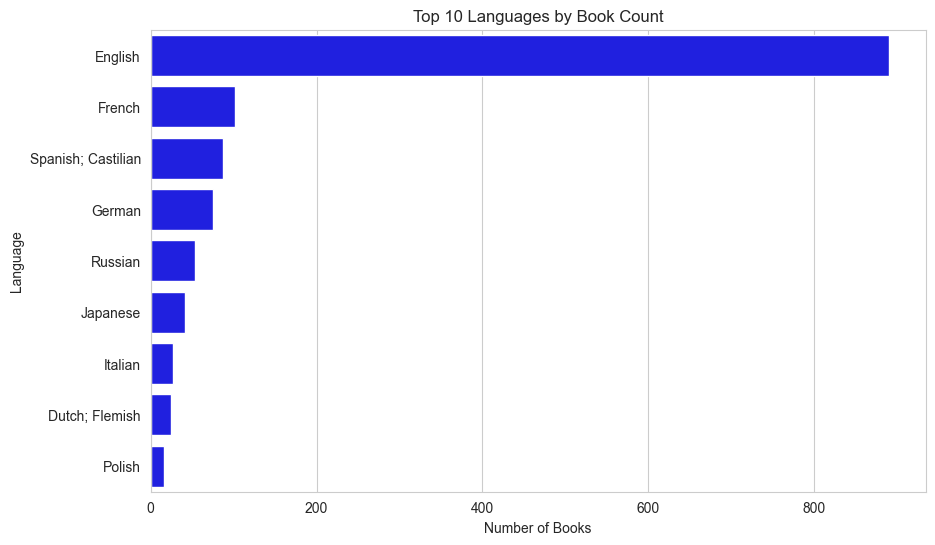

In [57]:
# ================================================
# 2. LANGUAGE DISTRIBUTION
# ================================================
language_counts = books_data['Language'].value_counts(dropna=False).reset_index()
language_counts.columns = ['Language', 'Count']

print("Language Distribution Table:")
display(language_counts)

# Visualize top 10 languages
top_n = 10
plt.figure(figsize=(10,6))
sns.barplot(data=language_counts.head(top_n), x='Count', y='Language', color='blue')
plt.title(f"Top {top_n} Languages by Book Count")
plt.xlabel("Number of Books")
plt.ylabel("Language")
plt.show()


**Analysis**:  
- As expected, **English** dominates, but there are many other translations (Spanish, French, etc.).  


<a id="authors-age--page-count"></a>
## 3. **Author's Age & Page Count**

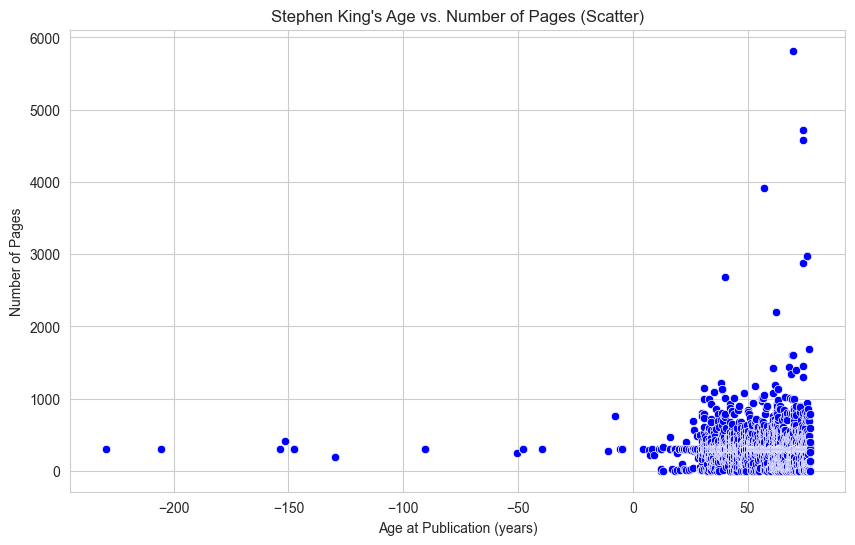

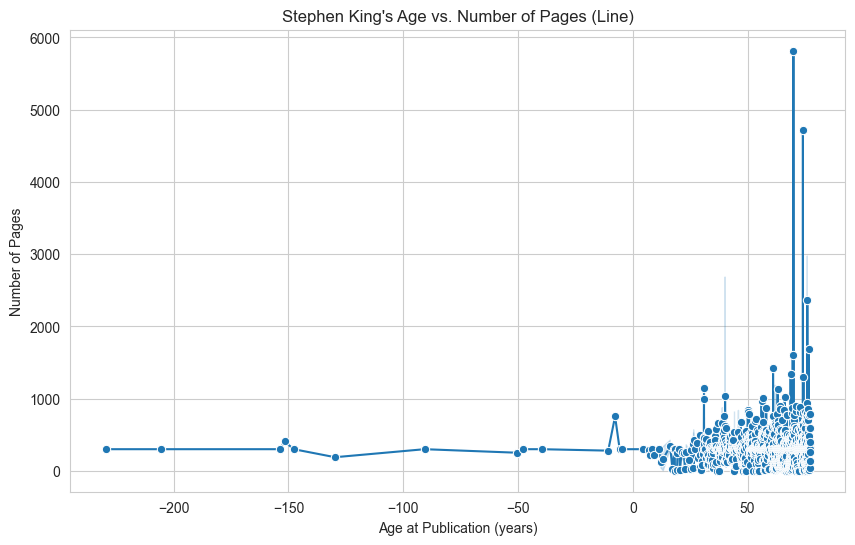

In [58]:
# ================================================
# 3. AUTHOR'S AGE & PAGE COUNT
# ================================================

age_pages_data = books_data.dropna(subset=['Age at Publication','Number of Pages']).copy()
age_pages_data.sort_values(by='Age at Publication', inplace=True)

# Scatter Plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=age_pages_data, 
    x='Age at Publication',
    y='Number of Pages',
    color='blue'
)
plt.title("Stephen King's Age vs. Number of Pages (Scatter)")
plt.xlabel("Age at Publication (years)")
plt.ylabel("Number of Pages")
plt.show()

# Optional: Line Plot
plt.figure(figsize=(10,6))
sns.lineplot(
    data=age_pages_data,
    x='Age at Publication',
    y='Number of Pages',
    marker='o'
)
plt.title("Stephen King's Age vs. Number of Pages (Line)")
plt.xlabel("Age at Publication (years)")
plt.ylabel("Number of Pages")
plt.show()


**Analysis**:  
- The plots do **not** show a strong upward or downward trend in page count with King’s age.  
- Some of his longest novels appear at various points in his career.  

<a id="authors-age--rating"></a>
## 4. **Author's Age & Rating**

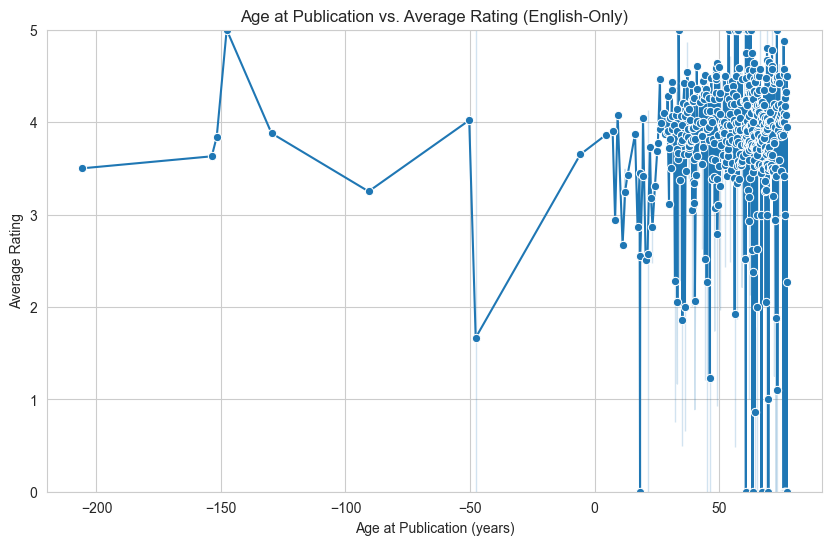

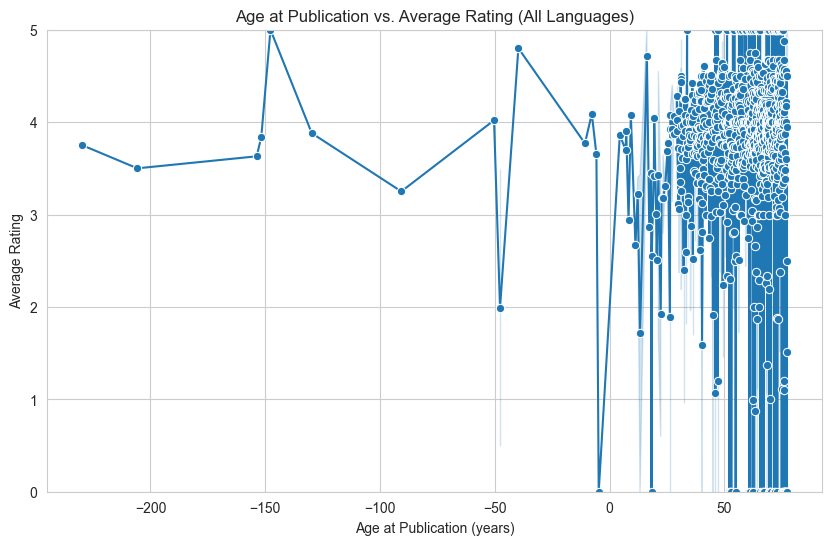

In [59]:
# ================================================
# 4. AUTHOR'S AGE & RATING
# ================================================

# (A) English-Only
english_books = books_data[
    (books_data['Language'].notnull()) &
    (books_data['Language'].str.contains("english", case=False, na=False))
].dropna(subset=['Age at Publication','Average Rating']).copy()

english_books.sort_values('Age at Publication', inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=english_books,
    x='Age at Publication',
    y='Average Rating',
    marker='o'
)
plt.title("Age at Publication vs. Average Rating (English-Only)")
plt.xlabel("Age at Publication (years)")
plt.ylabel("Average Rating")
plt.ylim(0,5)
plt.show()

# (B) All Languages
all_books = books_data.dropna(subset=['Age at Publication','Average Rating']).copy()
all_books.sort_values('Age at Publication', inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=all_books,
    x='Age at Publication',
    y='Average Rating',
    marker='o'
)
plt.title("Age at Publication vs. Average Rating (All Languages)")
plt.xlabel("Age at Publication (years)")
plt.ylabel("Average Rating")
plt.ylim(0,5)
plt.show()


**Analysis**:  
- **English-only**: Generally stable ratings (often 3.5–4.5) across King’s career.  
- **All languages**: Similar pattern—no dramatic shift in ratings purely due to age.  


<a id="pages-vs-rating"></a>
## 5. **Pages vs. Rating**

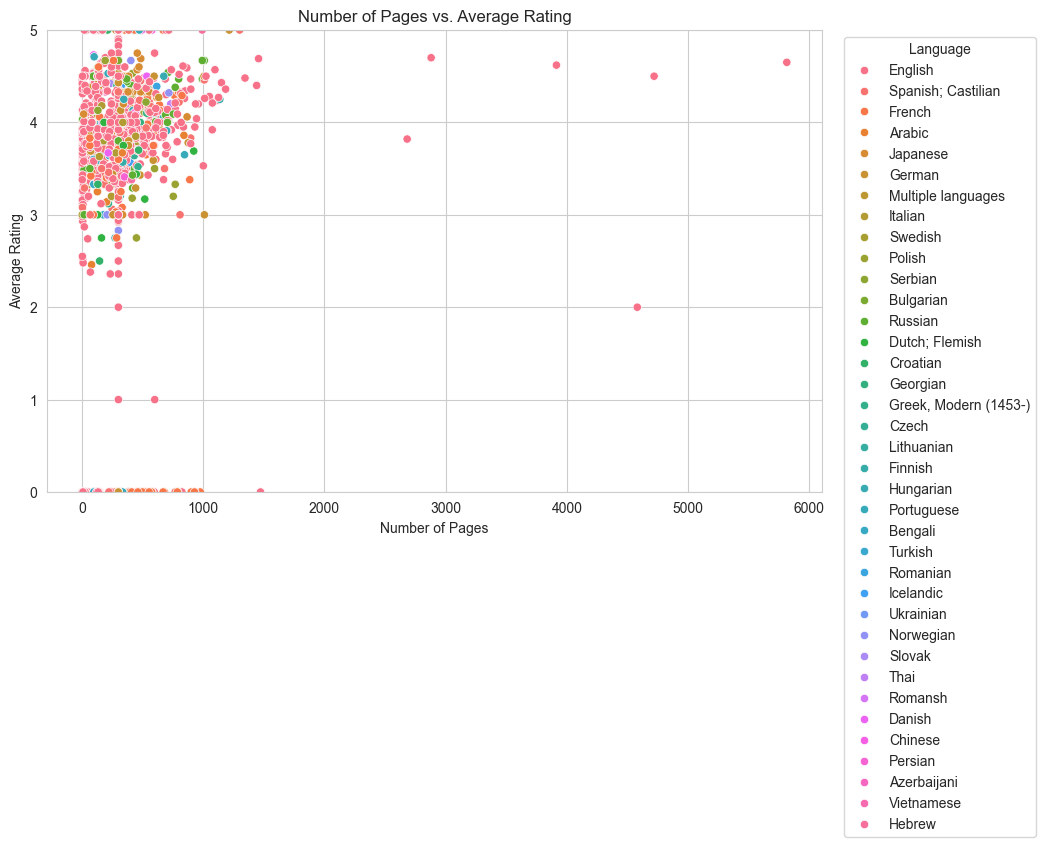

In [60]:
# ================================================
# 5. PAGES VS. RATING
# ================================================

pages_ratings_data = books_data.dropna(subset=['Number of Pages','Average Rating']).copy()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=pages_ratings_data,
    x='Number of Pages',
    y='Average Rating',
    hue='Language'
)
plt.title("Number of Pages vs. Average Rating")
plt.xlabel("Number of Pages")
plt.ylabel("Average Rating")
plt.ylim(0,5)
plt.legend(title="Language", bbox_to_anchor=(1.02,1), loc="upper left")
plt.show()

**Analysis**:  
- No strong linear relationship between page count and average rating.  
- Readers’ enjoyment is more about quality of content than mere length.  


<a id="interest-on-a-book-currently-reading-vs-ratings"></a>
## 6. **Interest on a Book: Currently Reading vs. Ratings**

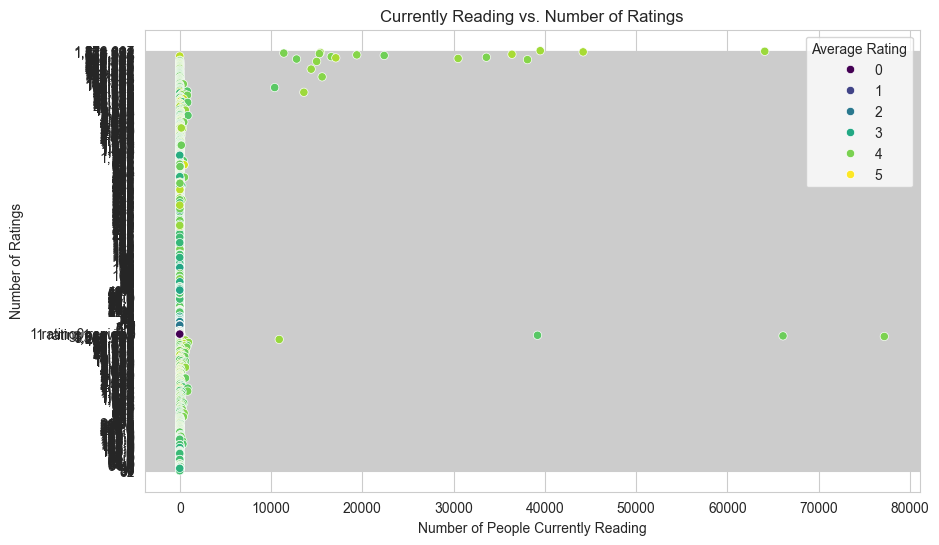

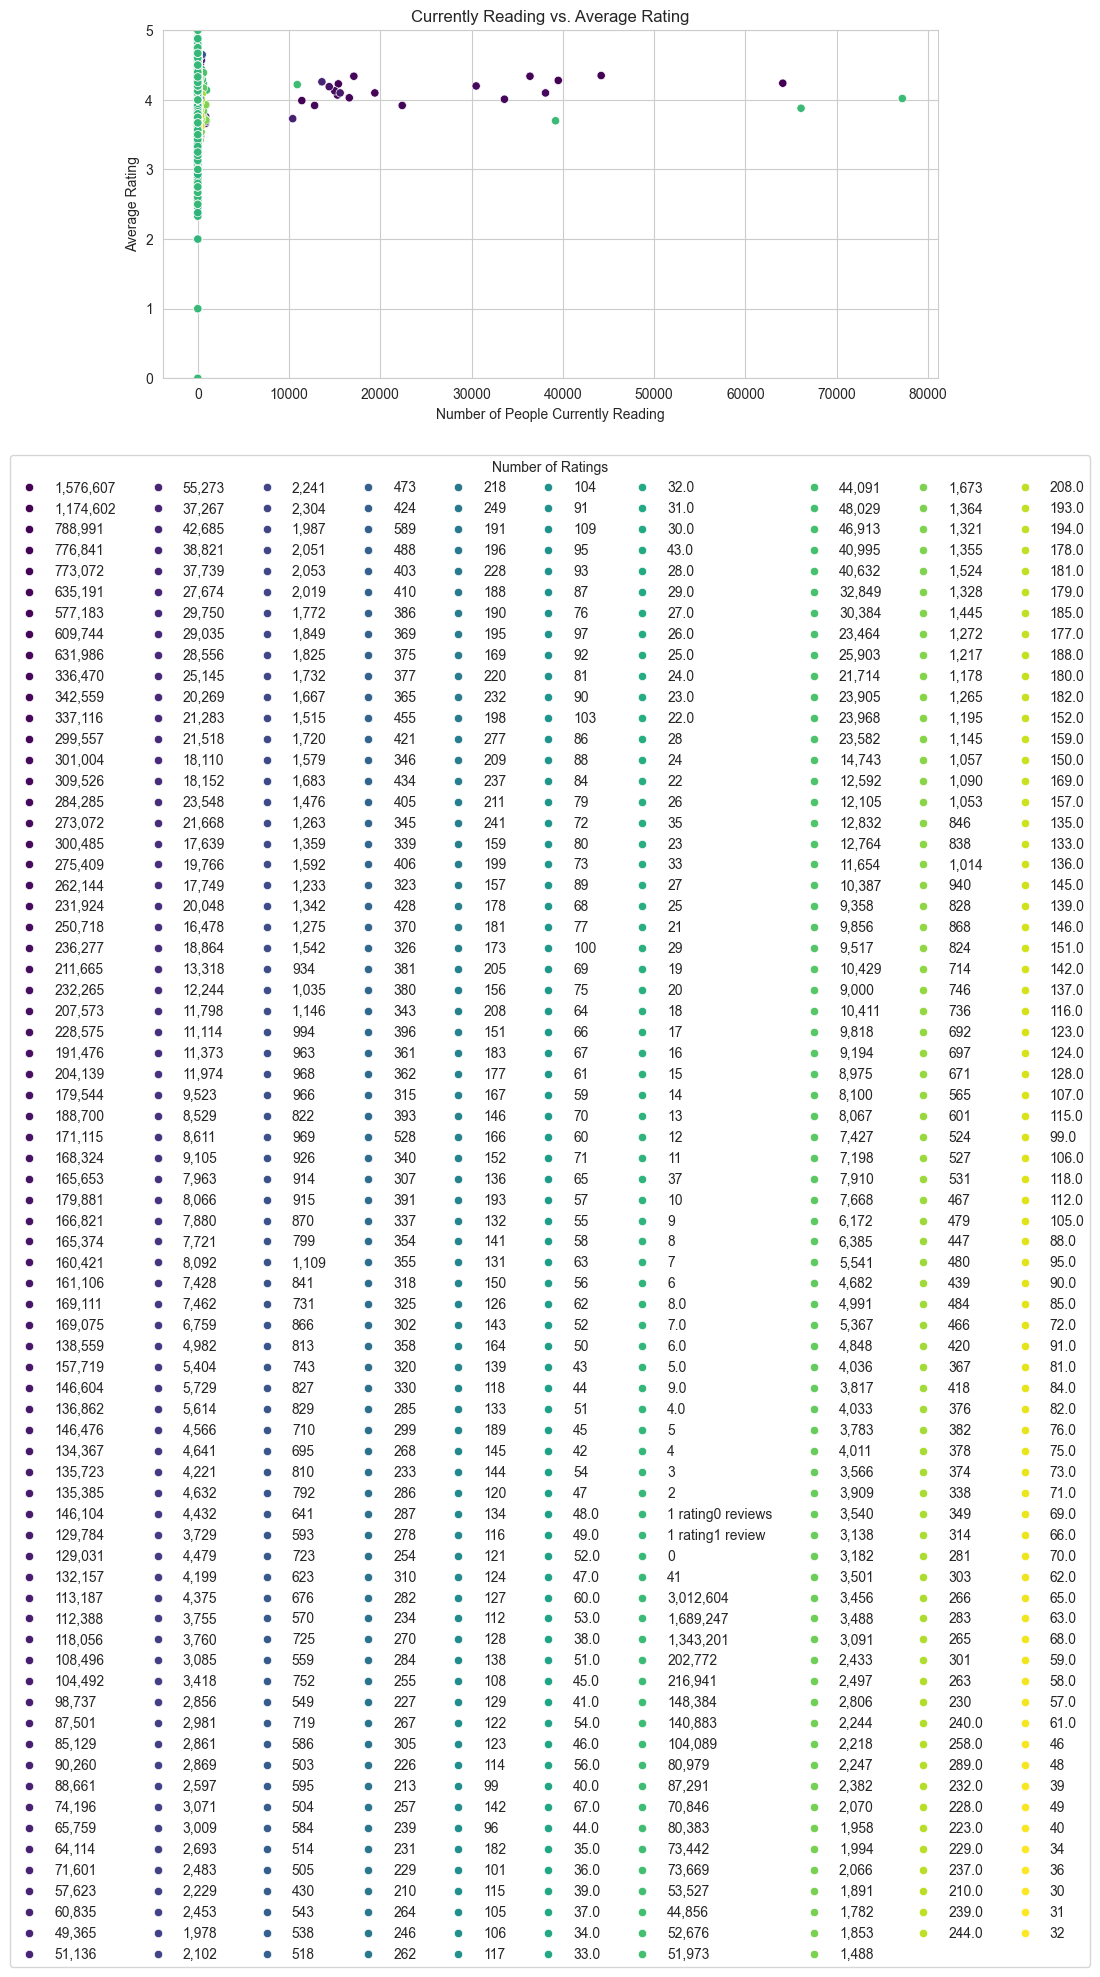

In [61]:
# ================================================
# 6. INTEREST ON A BOOK
# ================================================

interest_data = books_data.dropna(subset=['Currently Reading','Number of Ratings','Average Rating']).copy()

# (A) Currently Reading vs. Number of Ratings
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=interest_data,
    x='Currently Reading',
    y='Number of Ratings',
    hue='Average Rating',
    palette='viridis'
)
plt.title("Currently Reading vs. Number of Ratings")
plt.xlabel("Number of People Currently Reading")
plt.ylabel("Number of Ratings")
plt.show()

# (B) Currently Reading vs. Average Rating
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

scatter = sns.scatterplot(
    data=interest_data,
    x='Currently Reading',
    y='Average Rating',
    hue='Number of Ratings',
    palette='viridis',
    ax=ax
)

ax.set_title("Currently Reading vs. Average Rating")
ax.set_xlabel("Number of People Currently Reading")
ax.set_ylabel("Average Rating")
ax.set_ylim(0, 5)

# Force the legend to appear below the plot in a single (or multi-) row
# loc='upper center' means it will be centered horizontally
# bbox_to_anchor=(0.5, -0.2) places it below the axes
# ncol=10 is just an example; adjust columns to fit your data
legend = ax.legend(
    title="Number of Ratings",
    bbox_to_anchor=(0.5, -0.2),
    loc='upper center',
    ncol=10
)

# Add extra space at the bottom so the legend does not cut off
plt.subplots_adjust(bottom=0.3)

plt.show()



**Analysis**:
1. **Currently Reading vs. Number of Ratings**  
   - Books with lots of current readers often have many total ratings (popularity effect).  
   - Some older classics might have high total ratings but fewer *current* readers right now.  

2. **Currently Reading vs. Average Rating**  
   - Not much evidence that a high “current reading” count equals a higher average rating.  
   - Many factors affect a book’s rating, not just real-time popularity.  


<a id="conclusions"></a>
## 7. **Report Findings and Conclusions**

### Overview
This investigation into Stephen King’s bibliography encompassed various aspects of his work, including publication language, the relationship between his age and book length, the interplay of age and average ratings, the potential impact of page count on ratings, and the relationship between a book’s current readership and its overall reception. Through careful data collection, cleaning, and visualization, we derived a number of insights that provide a deeper understanding of Stephen King’s literary output and readers’ responses to his works.

---

### Language Distribution
The analysis of language distribution revealed a strong predominance of English-language publications, which reflects King’s primary audience and original publication market. Nonetheless, translations exist in a range of languages, most notably Spanish (Castilian), French, and German, indicating the worldwide appeal of his novels. Although these translations are fewer in number compared to English editions, their presence underscores Stephen King’s global readership and the broad availability of his work to diverse audiences.

---

### Author’s Age vs. Page Count
The comparison between Stephen King’s age at publication and the number of pages in his books did not reveal a definitive upward or downward trend. Longer novels, such as *It* and *The Stand*, appear at varying points throughout his career, suggesting that factors other than the author’s stage of life, such as genre or editorial decisions, likely have a greater influence on manuscript length. The lack of correlation implies that age does not constrain or encourage the production of lengthier texts in King’s oeuvre.

---

### Author’s Age vs. Average Rating
When separating English-only publications from all languages, we observed that books consistently achieved average ratings around 3.5 to 4.5, implying a generally high level of reader satisfaction. These ratings did not shift dramatically when translations were included, indicating that the point in King’s career at which a book was published does not strongly influence its critical reception. Rather, his works appear to maintain a stable and positive reputation, regardless of his age at the time of publication, suggesting a sustained quality that resonates with readers worldwide.

---

### Pages vs. Rating
The examination of whether the length of a book impacts its average rating also yielded minimal evidence of a strong correlation. While some shorter works achieve ratings comparable to more voluminous texts, and vice versa, it appears that the quality of storytelling, character development, and thematic depth may carry greater weight with readers than raw page count. Consequently, King’s success does not seem to hinge on the extent of his manuscripts; shorter offerings can be as highly regarded as his expansive novels.

---

### Interest on a Book: Currently Reading vs. Ratings
In exploring the relationship between the number of people currently reading a given work and its rating metrics, two key observations emerged. First, titles that attract substantial real-time readership often accrue a correspondingly large number of total ratings, which is consistent with the notion that popularity drives engagement and feedback. Second, however, there was no clear indication that a high number of current readers necessarily translates into elevated average ratings. While widespread awareness may boost a book’s visibility and the volume of ratings, the overall perception remains shaped by myriad factors beyond immediate popularity.

---

### Overall Conclusions
Taken together, these findings paint a picture of Stephen King’s continued prominence and broad appeal. His works reliably elicit favorable ratings across languages and chronological stages of his career, showcasing a sustained ability to captivate diverse readerships. Neither his age at publication nor the length of his novels appears determinative of critical reception or commercial interest, suggesting that the intrinsic qualities of his storytelling—ranging from horror to fantasy and beyond—likely hold greater significance in readers’ evaluations. Additionally, while high current readership rates may signal a book’s momentary popularity, they do not necessarily boost its average rating, highlighting the nuanced interplay between visibility, engagement, and sustained critical acclaim. Future research might compare these patterns with other prolific authors or delve into genre-specific analyses, examining how different types of **narratives** resonate with audiences over time.
